In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.gofplots import qqplot
from sklearn.model_selection import train_test_split

In [2]:
# Daten laden
# df = pd.read_csv('./data.csv')
df = pd.read_csv('./boston.csv')

# Daten vorverarbeiten
df = df.dropna()
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


#### Erklärung der Variablen zu Boston Dataset

Input features in order:
1) CRIM: per capita crime rate by town
2) ZN: proportion of residential land zoned for lots over 25,000 sq.ft.
3) INDUS: proportion of non-retail business acres per town
4) CHAS: Charles River dummy variable (1 if tract bounds river; 0 otherwise)
5) NOX: nitric oxides concentration (parts per 10 million) [parts/10M]
6) RM: average number of rooms per dwelling
7) AGE: proportion of owner-occupied units built prior to 1940
8) DIS: weighted distances to five Boston employment centres
9) RAD: index of accessibility to radial highways
10) TAX: full-value property-tax rate per $10,000 [$/10k]
11) PTRATIO: pupil-teacher ratio by town
12) B: The result of the equation B=1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
13) LSTAT: % lower status of the population

Output variable:
1) MEDV: Median value of owner-occupied homes in $1000's [k$]

#### Modellentwicklung

In [3]:
# Zielvariable und Prädiktoren definieren
# target = 'price'
# predictors = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 
#              'waterfront', 'view', 'condition', 'sqft_above', 'sqft_basement', 
#              'yr_built', 'yr_renovated']
target = 'MEDV'
predictors = df.columns.drop(target).tolist()
predictors = ['CHAS', 'CRIM', 'ZN']

# Daten für das Modell vorbereiten
X = df[predictors]
y = df[target]
X = sm.add_constant(X)  # Adds a constant term to the predictor

# Modell erstellen und fitten
model = sm.OLS(y, X).fit()

# Modellzusammenfassung anzeigen
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.258
Method:                 Least Squares   F-statistic:                     59.67
Date:                Thu, 30 May 2024   Prob (F-statistic):           5.23e-33
Time:                        18:28:43   Log-Likelihood:                -1763.1
No. Observations:                 506   AIC:                             3534.
Df Residuals:                     502   BIC:                             3551.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         21.9715      0.449     48.937      0.0

- **R-squared (R²)**: Ein Maß für die Güte der Anpassung des Modells. Es gibt an, welcher Anteil der Varianz in der abhängigen Variable durch die unabhängigen Variablen erklärt wird. Ein Wert von 1 bedeutet perfekte Anpassung, ein Wert von 0 bedeutet, dass das Modell keine erklärende Kraft hat.
- **Adj. R-squared**: Anpassung des R²-Werts, der die Anzahl der Prädiktoren berücksichtigt. Er gibt eine realistischere Einschätzung der Modellgüte, besonders wenn viele Prädiktoren verwendet werden.
- **F-statistic und Prob (F-statistic)**: Der F-Test prüft, ob das Modell insgesamt signifikant ist. Ein kleiner p-Wert (unter 0.05) deutet darauf hin, dass das Modell signifikant ist.
- **Coefficients**: Die Koeffizienten der unabhängigen Variablen im Modell. Diese Werte zeigen die geschätzte Änderung in der abhängigen Variable für eine Einheit Änderung der jeweiligen unabhängigen Variable.
- **P>|t| für jeden Koeffizienten**: Der p-Wert für den t-Test der Nullhypothese, dass der Koeffizient gleich Null ist. Ein kleiner p-Wert (unter 0.05) deutet darauf hin, dass der Koeffizient signifikant von Null abweicht.

#### Signifikanztests

In [4]:
# Parameter Signifikanz
parameter_p_values = model.summary2().tables[1]['P>|t|']
print("Parameter Signifikanz:")
print(parameter_p_values)

# Modell Signifikanz
model_f_pvalue = model.f_pvalue
print("Modell Signifikanz:")
print(model_f_pvalue)

Parameter Signifikanz:
const    3.354957e-193
CHAS      1.131516e-05
CRIM      3.958586e-15
ZN        4.765846e-14
Name: P>|t|, dtype: float64
Modell Signifikanz:
5.2300422014589025e-33


**Ergebnis**: Parameter Signifikanz

- **P-Werte für jeden Parameter**: Diese zeigen, ob jeder einzelne Prädiktor signifikant zur Vorhersage der abhängigen Variable beiträgt. Ein p-Wert unter 0.05 deutet darauf hin, dass der entsprechende Prädiktor signifikant ist.

**Ergebnis**: Modell Signifikanz

- **F-Statistik p-Wert**: Dieser Wert gibt an, ob das gesamte Modell signifikant ist. Ein p-Wert unter 0.05 bedeutet, dass das Modell insgesamt signifikant ist und dass zumindest ein Prädiktor einen signifikanten Einfluss auf die abhängige Variable hat.

#### Ex-ante Prognose und Prognosefehler

In [5]:
# Daten in Trainings- und Testdatensatz aufteilen
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

# Trainingsdaten für das Modell vorbereiten
X_train = train_data[predictors]
y_train = train_data[target]
X_train = sm.add_constant(X_train)

# Modell auf Trainingsdaten erstellen und fitten
model = sm.OLS(y_train, X_train).fit()

# Testdaten vorbereiten
X_test = test_data[predictors]
y_test = test_data[target]
X_test = sm.add_constant(X_test)

# Ex-ante Prognose durchführen
ex_ante_predictions = model.predict(X_test)

# Prognosefehler berechnen
forecast_error = np.mean((ex_ante_predictions - y_test) ** 2)
print("Ex-ante Prognosefehler:")
print(forecast_error)

# Final Prediction Error (FPE) für das Modell auf den Trainingsdaten
n = model.nobs
k = model.df_model + 1
residual_sum_of_squares = model.ssr
fpe = residual_sum_of_squares / (n - k - 1)
print("Final Prediction Error (FPE):")
print(fpe)

Ex-ante Prognosefehler:
47.187360369477005
Final Prediction Error (FPE):
67.16807095323574


**Ergbenis**: Ex-ante Prognosefehler

- **Forecast Error (Prognosefehler)**: Dieser Wert misst die durchschnittliche Abweichung der Vorhersagen des Modells von den tatsächlichen Werten in den Testdaten. Ein kleinerer Wert deutet auf eine bessere Vorhersagegenauigkeit des Modells hin.

**Ergebnis**: Final Prediction Error (FPE)

- **FPE**: Ein Maß zur Bewertung der Modellgenauigkeit, das sowohl die Varianz der Schätzfehler als auch die Anzahl der Prädiktoren im Modell berücksichtigt. Ein kleinerer Wert deutet auf eine bessere Modellgenauigkeit hin.


#### Test der Modellannahmen

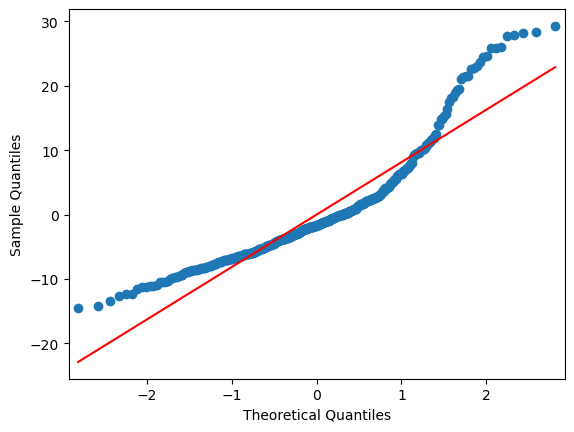

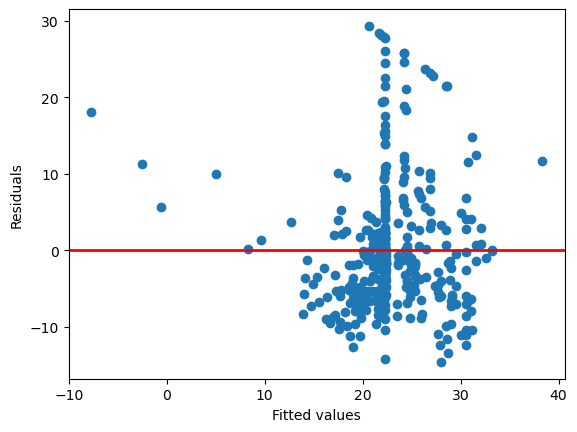

Multikollinearität:
   VIF Factor features
0    1.008902     CHAS
1    1.002737     CRIM
2    1.006163       ZN


In [6]:
# Normalität der Residuen testen
residuals = model.resid
qqplot(residuals, line='s')
plt.show()

# Homoskedastizität der Residuen testen
fitted = model.fittedvalues
plt.scatter(fitted, residuals)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.axhline(0, color='red', linewidth=2)
plt.show()

# Multikollinearität testen
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df[predictors]
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
print("Multikollinearität:")
print(vif)

**Ergebnis**: Normalität der Residuen

- **Q-Q-Plot der Residuen**: Dies ist eine grafische Darstellung zur Überprüfung, ob die Residuen (Fehlerterme) des Modells einer Normalverteilung folgen. Wenn die Punkte im Q-Q-Plot entlang der Diagonalen liegen, deutet dies darauf hin, dass die Residuen normal verteilt sind.

**Ergebnis**: Homoskedastizität der Residuen

- **Streudiagramm der Residuen gegen die vorhergesagten Werte**: Dieses Diagramm zeigt, ob die Varianz der Residuen konstant bleibt (Homoskedastizität) oder sich ändert (Heteroskedastizität). Eine gleichmäßige Streuung der Punkte deutet auf Homoskedastizität hin, während ein Muster auf Heteroskedastizität hinweist.

**Ergebnis**: Multikollinearität

- **Variance Inflation Factor (VIF)**: Diese Werte zeigen, ob es Multikollinearität zwischen den Prädiktoren gibt. Ein VIF-Wert über 10 deutet auf eine hohe Korrelation und damit auf Multikollinearität hin, was die Schätzung der Koeffizienten destabilisieren kann.

### TODO's:

- A. Korrelationsplot und Auswahl der Regressoren + Beschreibung (Niclas und Luis)
- B. Boxplots für AV und Regressoren (Marc)
1. Modellentwicklung (Marc) 
2. Signifikanztest (Marc)
3. Test der Modellannahmen (Luis)
4. Ex-Ante Prognose (Niclas)

- Sonntag Finales Meeting.